#CMSC498L HW 3: Image and movie review classification.

File imports...

In [ ]:
from tqdm import tqdm   #Just to make my loops beautiful.
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms
import h5py
from torchvision import datasets, transforms, models

## Step 1: Data loading and preroceesing steps

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
# %reload_ext autoreload
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
!ls
np.random.seed(1)
%cd drive/My\ Drive
# !pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
drive  sample_data
/content/drive/My Drive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  # Remove the CWD from sys.path while we load stuff.


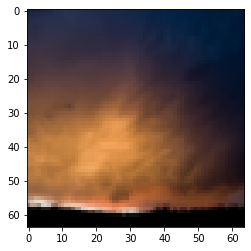

In [ ]:
def load_data(train_file, test_file):
    # Load the training data
    train_dataset = h5py.File(train_file)
    # Separate features(x) and labels(y) for training set
    # print(list(train_dataset))
    train_set_x_orig = train_dataset['train_set_x']
    train_set_y_orig = train_dataset['train_set_y']
    # print(type(train_set_y_orig))
    # Load the test data
    test_dataset = h5py.File(test_file)
    
    # # Separate features(x) and labels(y) for training set
    # print(list(test_dataset))
    test_set_x_orig = test_dataset['test_set_x']
    test_set_y_orig = test_dataset['test_set_y']

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    # print(type(train_set_y_orig))
    train_set_y_orig = np.array(train_set_y_orig)
    test_set_y_orig = np.array(test_set_y_orig)
    # train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    # test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes
train_file="train_catvnoncat.h5"
test_file="test_catvnoncat.h5"
train_x_orig, train_y, test_x_orig, test_y, classes = \
load_data(train_file, test_file)
plt.imshow(train_x_orig[0])
train_y_dummy=np.reshape(train_y,(-1,1))
test_y_dummy=np.reshape(test_y,(-1,1))
# print(np.shape(train_y_dummy))

In [ ]:
# Reshape the training and test examples 
train_x_orig = np.array(train_x_orig)
test_x_orig = np.array(test_x_orig)
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.
train_x = torch.Tensor(train_x.T).float()
test_x = torch.Tensor(test_x.T).float()
test_y = torch.LongTensor(test_y).float()
train_y = torch.LongTensor(train_y).float()
# validation data?
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
training_data = train_x
training_labels = train_y
test_data = test_x
test_labels = test_y
val_data = test_data 
val_labels = test_labels
print(training_data.shape)

train_x's shape: torch.Size([209, 12288])
test_x's shape: torch.Size([50, 12288])
torch.Size([209, 12288])


#Step 2: Optimizer and loss function definition

Model Description: Input -> ReLU -> Hidden Layer -> Sigmoid -> Output layer

In [ ]:
class Net(nn.Module):   
    def __init__(self, flag, n_x, n_h, n_y):
        super(Net, self).__init__()
        layer0 = n_x
        layer1 = n_h
        layer2 = n_y
        self.fc1 = nn.Linear(layer0, layer1, bias = True) 
        self.fc1.bias.data.fill_(0) 
        self.fc2 = nn.Linear(layer1, layer2, bias = True) 
        self.fc2.bias.data.fill_(0)
        self.dropout1 = nn.Dropout(0.5)
        self.dense1_bn = nn.BatchNorm1d(7)

        torch.manual_seed(1)

        if flag == 1:
          nn.init.xavier_uniform_(self.fc1.weight)        
          nn.init.xavier_uniform_(self.fc2.weight)
          
        elif flag == 2:
          # nn.init.normal_(self.fc1.weight)
          y = 1.0/np.sqrt(layer0)
          self.fc1.weight.data.normal_(-y, y)
          # nn.init.normal_(self.fc2.weight)
          y = 1.0/np.sqrt(layer1)
          self.fc2.weight.data.normal_(-y, y)

        elif flag ==3:
          nn.init.kaiming_normal_(self.fc1.weight,nonlinearity='relu')
          nn.init.kaiming_normal_(self.fc2.weight)

        elif flag == 4:
          nn.init.xavier_normal_(self.fc1.weight)        
          nn.init.xavier_normal_(self.fc2.weight)

        elif flag == 5:
          y = 1.0/layer0*layer1
          self.fc1.weight.data.normal_(-y, y)
          # nn.init.normal_(self.fc2.weight)
          y = 1.0/layer1*layer2
          self.fc2.weight.data.normal_(-y, y)
        
    def forward(self, x):     #This is the forward propagation function which will be called everytime during forward pass
        #x is the input that we will give in the network.
        x = self.fc1(x) #Passsing the function through the first Fully connected layer
        # x = self.dense1_bn(x) # Batch norm
        x = torch.relu(x) #Applying the sigmoid activation to the outputof the first fc layer
        # x=self.dropout1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x


In [ ]:
def my_model(flag, n_x, n_h, n_y):
  global model, loss_function, optim
  model = Net(flag, n_x, n_h, n_y)  
  loss_function = nn.BCELoss()
  optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

This function calculates the accuracy of the model, given data and labels

In [ ]:
def accuracy(test_data, test_labels):
  global model, loss_function, optim
  model.eval()  #Setting the model to eval mode, hence making it deterministic.

  with torch.no_grad():   
    
    model_output = np.array(model(test_data)).flatten()
    test_labels = np.array(test_labels)

    classification = np.where(model_output >= 0.5, 1, 0)
    correct_class = np.where(classification-test_labels == 0, 1, 0)
    return np.mean(correct_class)

This is where the model is trained 

In [ ]:
def model_train(train_data, train_labels, valid_data, valid_labels,
                batch_size, learning_rate, momentum, epochs, weight_decay, step_size, gamma, option, milestone):
  epoch_loss=[]
  epoch_val_loss = []
  epoch_accuracy = []
  epoch_val_accuracy = []
   
  scheduler = 0
  if option==1:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, step_size)
  elif option==2:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, step_size)
  elif option==3:
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=step_size, gamma=gamma)
  elif option==4:
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestone, gamma=gamma)
 
  for epoch in range(epochs):
    model.train()  
    train_loss = []
    if scheduler:
        scheduler.step()
    model_output = 0
    for idx in range(0, train_data.shape[0], batch_size): 
      
      batch_data = train_data[idx : idx+batch_size]  
      batch_labels = train_labels[idx : idx+batch_size] 
      
      model_output = model(batch_data)  
      loss = loss_function(model_output, batch_labels.view(-1,1)) 
      train_loss.append(loss.item())

      optim.zero_grad()  
      loss.backward()    
      optim.step()  

    epoch_accuracy.append( accuracy(train_data, train_labels) )

    #Validation phase
    model.eval()  
    val_loss = [] # to store the validation loss 
    
    for idx in range(0, valid_data.shape[0], batch_size):

      with torch.no_grad():   

        batch_data = valid_data[idx : idx+batch_size] 
        batch_labels = valid_labels[idx:idx+batch_size]
        model_output = model(batch_data)
        loss = loss_function(model_output, batch_labels.view(-1,1))
        val_loss.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_loss))
    epoch_loss.append(np.mean(train_loss))
    epoch_val_accuracy.append( accuracy(valid_data, valid_labels) )

    if epoch % 100 == 0:
      # print('mean = {}, std = {}'.format(model_output.mean(), model_output.std()))
      print("{}:  Train loss: {}, Val loss: {}, Train acc: {}, Val acc: {}".format(epoch, round(np.mean(train_loss),2),round(np.mean(val_loss),2),epoch_accuracy[-1],epoch_val_accuracy[-1]))
  return epoch_loss,epoch_val_loss,epoch_accuracy,epoch_val_accuracy

This function is for data visualization

In [ ]:
def display_vals(train_data, train_labels, t_data, t_labels,
                 which_weight,epoch_loss,epoch_val_loss,epoch_accuracy,epoch_val_accuracy, learning_rate, momentum, batch_size, epochs, option, step_size, gamma, weight_decay):
  global model, loss_function, optim
  plt.plot(np.squeeze(epoch_loss), label="train loss")
  plt.plot(np.squeeze(epoch_val_loss), label="val loss")
  plt.plot(np.squeeze(epoch_accuracy), label="train accuracy")
  plt.plot(np.squeeze(epoch_val_accuracy), label="val accuracy")

  plt.legend(loc="upper right")
  plt.ylabel('loss/accuracy', color='w')
  plt.xlabel('epochs', color='w')
  plt.title("Learning rate = {}, momentum = {}".format(learning_rate,momentum), color='w')
  plt.show()
  train_accuracy = accuracy(train_data, train_labels)
  test_accuracy = accuracy(t_data, t_labels)
  print('train accuracy = {}, test accuracy = {}'.format(train_accuracy,test_accuracy))

  print('batch_size = {}'.format(batch_size))
  print('epochs = {}'.format(epochs))
  print('weight_decay = {}'.format(weight_decay))
  print('option = {}, step_size = {}, gamma = {}'.format(option,step_size, gamma))
  print('which_weight = {}'.format(which_weight))

This is where you do all edits

0:  Train loss: 0.68, Val loss: 0.73, Train acc: 0.6889952153110048, Val acc: 0.38
100:  Train loss: 0.38, Val loss: 0.53, Train acc: 0.9234449760765551, Val acc: 0.76
200:  Train loss: 0.28, Val loss: 0.47, Train acc: 0.9569377990430622, Val acc: 0.82
300:  Train loss: 0.25, Val loss: 0.46, Train acc: 0.9665071770334929, Val acc: 0.8
400:  Train loss: 0.24, Val loss: 0.46, Train acc: 0.9760765550239234, Val acc: 0.8
500:  Train loss: 0.23, Val loss: 0.46, Train acc: 0.9760765550239234, Val acc: 0.8
600:  Train loss: 0.23, Val loss: 0.46, Train acc: 0.9760765550239234, Val acc: 0.82
700:  Train loss: 0.23, Val loss: 0.47, Train acc: 0.9760765550239234, Val acc: 0.8
800:  Train loss: 0.23, Val loss: 0.46, Train acc: 0.9760765550239234, Val acc: 0.8
900:  Train loss: 0.23, Val loss: 0.46, Train acc: 0.9760765550239234, Val acc: 0.8
1000:  Train loss: 0.23, Val loss: 0.46, Train acc: 0.9808612440191388, Val acc: 0.84
1100:  Train loss: 0.23, Val loss: 0.46, Train acc: 0.9808612440191388, 

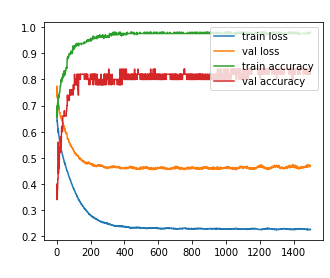

train accuracy = 0.9808612440191388, test accuracy = 0.84
batch_size = 30
epochs = 1500
weight_decay = 0.17
option = 0, step_size = 100, gamma = 0.01
which_weight = 4


In [ ]:
batch_size =30
learning_rate = 0.002
momentum = 0.7
epochs = 1500
weight_decay = 0.17 # L2 regularization param
# For the lr schedular
step_size = 100
gamma = 0.01
milestone = [300,1500]
option = 0 # use 0 or 3 ; 4: period decay
which_weight = 4 # 1: xavier uniform, 2: normal sampling sqrt 3: He, 4: xavier normal 5: normal sampling inputs
my_model(which_weight, 12288, 7, 1) # n_x, n_h, n_y
epoch_loss,epoch_val_loss,epoch_accuracy,epoch_val_accuracy = model_train(training_data, training_labels, val_data, val_labels, batch_size, learning_rate, 
                                                                          momentum, epochs, weight_decay, step_size, gamma, option, milestone)
display_vals(training_data, training_labels, test_data, test_labels,which_weight,epoch_loss,epoch_val_loss,epoch_accuracy,epoch_val_accuracy, learning_rate, 
             momentum, batch_size, epochs, option, step_size, gamma, weight_decay)

##Part 2: Movie Review sentiment prediction

In [ ]:
def load_data(train_file, test_file):
    train_dataset = []
    test_dataset = []
    
    # Read the training dataset file line by line
    for line in open(train_file, 'r'):
        train_dataset.append(line.strip())
        
    for line in open(test_file, 'r'):
        test_dataset.append(line.strip())
    return train_dataset, test_dataset
train_file = "train_imdb.txt"
test_file = "test_imdb.txt"
train_dataset, test_dataset = load_data(train_file, test_file)
# This is just how the data is organized. The first 50% data is positive and the rest 50% is negative for both train and test splits.
y = [1 if i < len(train_dataset)*0.5 else 0 for i in range(len(train_dataset))]

Number of training examples: 1001
Number of testing examples: 201


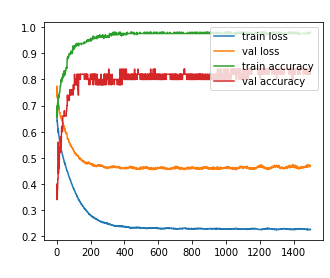

train accuracy = 0.9808612440191388, test accuracy = 0.84
batch_size = 30
epochs = 1500
weight_decay = 0.17
option = 0, step_size = 100, gamma = 0.01
which_weight = 4


In [ ]:
# Explore your dataset 
m_train = len(train_dataset)
m_test = len(test_dataset)

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))

Pre-Processing

In [ ]:
import re
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

def preprocess_reviews(reviews):
    
    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in reviews]
    
    return reviews

train_dataset_clean = preprocess_reviews(train_dataset)
test_dataset_clean = preprocess_reviews(test_dataset)

Vectorization

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True, stop_words="english", max_features=2000)
cv.fit(train_dataset_clean)
X = cv.transform(train_dataset_clean)
X_test = cv.transform(test_dataset_clean)
X = np.array(X.todense()).astype(float)
X_test = np.array(X_test.todense()).astype(float)
y = np.array(y)

Model

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.80
)
# This is just to correct the shape of the arrays as required by the two_layer_model
X_train = torch.Tensor(X_train).float()
X_val = torch.Tensor(X_val).float()
y_train = torch.LongTensor(y_train).float()
y_val = torch.LongTensor(y_val).float()
### CONSTANTS DEFINING THE MODEL ####

n_x = X_train.shape[1]
n_h = 200
n_y = 1
my_model(which_weight, n_x, n_h, n_y) 
epoch_loss,epoch_val_loss,epoch_accuracy,epoch_val_accuracy = model_train(X_train, y_train, X_val, y_val, batch_size, learning_rate, momentum, 
                                                                          epochs, weight_decay, step_size, gamma, option, milestone)
# display_vals(X_train, y_train, X_val, y_val, which_weight,epoch_loss,epoch_val_loss,epoch_accuracy,epoch_val_accuracy, learning_rate, 
#              momentum, batch_size, epochs, option, step_size, gamma, weight_decay)

0:  Train loss: 0.71, Val loss: 0.69, Train acc: 0.4525, Val acc: 0.5174129353233831
100:  Train loss: 0.6, Val loss: 0.61, Train acc: 0.915, Val acc: 0.8706467661691543
200:  Train loss: 0.57, Val loss: 0.59, Train acc: 0.9225, Val acc: 0.8756218905472637
300:  Train loss: 0.56, Val loss: 0.59, Train acc: 0.92375, Val acc: 0.8756218905472637
400:  Train loss: 0.56, Val loss: 0.58, Train acc: 0.925, Val acc: 0.8805970149253731
500:  Train loss: 0.56, Val loss: 0.58, Train acc: 0.92625, Val acc: 0.8805970149253731
600:  Train loss: 0.56, Val loss: 0.58, Train acc: 0.92625, Val acc: 0.8805970149253731
700:  Train loss: 0.56, Val loss: 0.58, Train acc: 0.92625, Val acc: 0.8805970149253731
800:  Train loss: 0.56, Val loss: 0.58, Train acc: 0.92625, Val acc: 0.8805970149253731
900:  Train loss: 0.56, Val loss: 0.58, Train acc: 0.92625, Val acc: 0.8805970149253731
1000:  Train loss: 0.56, Val loss: 0.58, Train acc: 0.92625, Val acc: 0.8805970149253731
1100:  Train loss: 0.56, Val loss: 0.58,

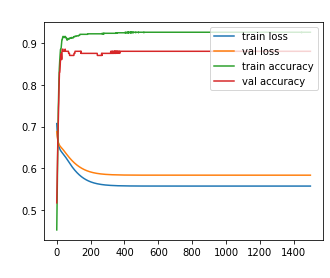

train accuracy = 0.92625, test accuracy = 0.8805970149253731
batch_size = 30
epochs = 1500
weight_decay = 0.17
option = 0, step_size = 100, gamma = 0.01
which_weight = 4


In [ ]:
# display_vals(X_train, y_train, X_val, y_val, which_weight,epoch_loss,epoch_val_loss,epoch_accuracy,epoch_val_accuracy, learning_rate, 
#              momentum, batch_size, epochs, option, step_size, gamma, weight_decay)
plt.plot(np.squeeze(epoch_loss), label="train loss")
plt.plot(np.squeeze(epoch_val_loss), label="val loss")
plt.plot(np.squeeze(epoch_accuracy), label="train accuracy")
plt.plot(np.squeeze(epoch_val_accuracy), label="val accuracy")

plt.legend(loc="upper right")
plt.ylabel('loss/accuracy', color='w')
plt.xlabel('epochs', color='w')
plt.title("Learning rate = {}, momentum = {}".format(learning_rate,momentum), color='w')
plt.show()
train_accuracy = accuracy(X_train, y_train)
test_accuracy = accuracy(X_val, y_val)
print('train accuracy = {}, test accuracy = {}'.format(train_accuracy,test_accuracy))

print('batch_size = {}'.format(batch_size))
print('epochs = {}'.format(epochs))
print('weight_decay = {}'.format(weight_decay))
print('option = {}, step_size = {}, gamma = {}'.format(option,step_size, gamma))
print('which_weight = {}'.format(which_weight))